# Example 1: 1D Gaussian Mixture

In this example we'll take a 1D toy PDF (namely, a 3 component Gaussian mixture) and look at drawing samples from it in various ways.

It's worth pointing out that this is, in some sense, a bad example. There are ways to easily and efficiently sample from Gaussian distributions without making the linear approximations employed by `lintsampler`. The point of this example is merely to demonstrate the ways `lintsampler` can be used with a 1D PDF.

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

## GMM model

We'll test a 3-component 1D Gaussian mixture model. Below we'll define a function which evaluates the PDF as a function of $x$. The means / widths / weights of the three Gaussian components are stored in the arrays `mu`, `sig` and `w` respectively. This implementation is vectorized (i.e., it takes a sequence of positions and spits out a sequence of densities), but in general `lintsampler` can take both vectorized and non-vectorized PDFs.

In [4]:
def gmm_pdf(x):
    mu = np.array([-3.0, 0.5, 2.5])
    sig = np.array([1.0, 0.25, 0.75])
    w = np.array([0.4, 0.25, 0.35])
    return np.sum([w[i] * norm.pdf(x, mu[i], sig[i]) for i in range(3)], axis=0)


Let's visualise the PDF:

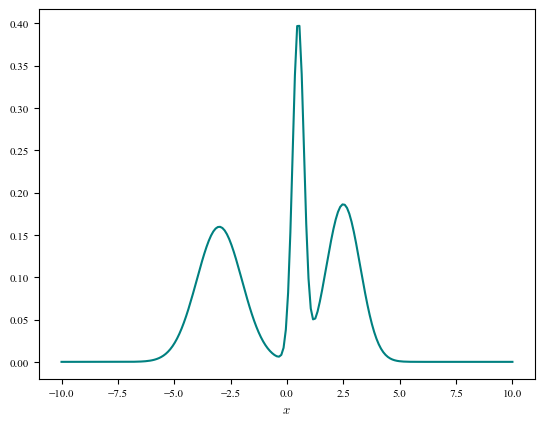

In [5]:
x = np.linspace(-10, 10, 200)
plt.plot(x, gmm_pdf(x), c='teal')
plt.xlabel('$x$', usetex=True);

## `First approach`: fixed grid

Here we'll take a fixed grid with 32 cells from $x=-12$ to $x=12$, and use `LintSampler` to draw a million samples. First import `LintSampler`:

In [6]:
from lintsampler import LintSampler

Set up the grid, and evaluate the PDF at the grid edges (note that the grid has 32 cells, so 33 edges):

In [7]:
N_cells = 32
x_min = -12
x_max = 12
fixedgrid = np.linspace(x_min,x_max,N_cells+1)

Create the `LintSampler` object, passing in the pdf and desired cell structure.

In [8]:
L = LintSampler(fixedgrid,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)

Draw samples:

In [9]:
samples = L.sample(N=1000000)

Now we can visualise the samples, and compare with the true PDF.

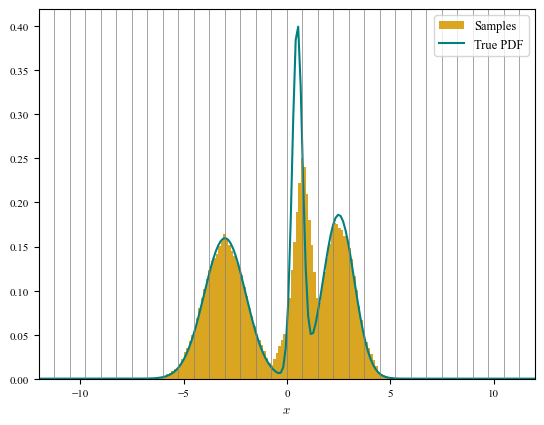

In [10]:
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12)
ylim = plt.gca().get_ylim()
for edge in fixedgrid:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

This does a pretty good job! Could be better, particularly close to the Gaussian peaks. The problem here is insufficient grid resolution. One could either increase the number of grid cells, or adopt a variable grid with more resolution where needed. We'll try the latter.

## `Second approach`: Variable grid

Now we can set up a variable grid, again with 32 cells, but now with more resolution in the relevant regions and less resolution elsewhere. Here I just hard-code the array of edges, but of course one could imagine doing something smarter.

In [11]:
variablegrid = np.hstack([
    np.linspace(-12, -5, 4, endpoint=False),
    np.linspace(-5, -0, 8, endpoint=False),
    np.linspace(0, 5, 16, endpoint=False),
    np.linspace(5, 12, 5, endpoint=True),
])

L = LintSampler(variablegrid,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)

Draw samples:

In [12]:
samples = L.sample(N=1000000)

Visualise:

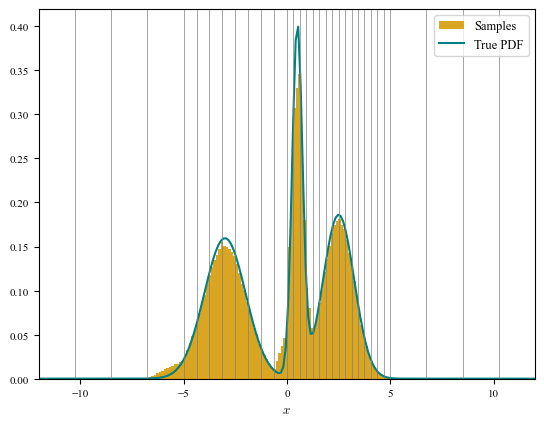

In [13]:
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12)
ylim = plt.gca().get_ylim()
for edge in variablegrid:
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

That's better!

## `Third Approach`: Separate grids

We are not required to have one continuous grid as the input to `LintSampler`. In fact, in this case, with three distinct peaks, we might want to consider grids that only sample around the peaks. We'll pass a list of three grids, centred at the peaks.

In [14]:
peakgrids = [
    np.linspace(-5., -1., 12),
    np.linspace(0., 1., 12),
    np.linspace(1.25, 3.75, 12),
]

L = LintSampler(peakgrids,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)

Draw samples:

In [15]:
samples = L.sample(N=1000000)

Visualise:

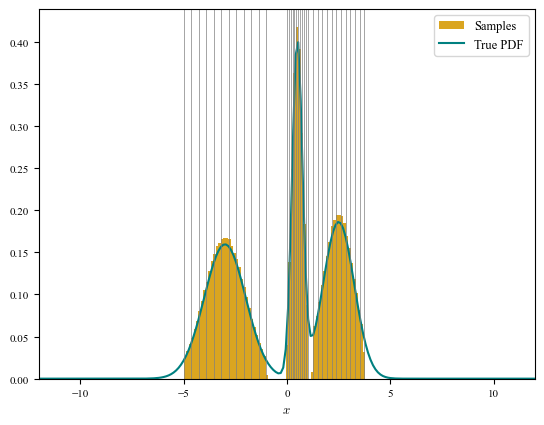

In [16]:
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12)
ylim = plt.gca().get_ylim()
for edge in np.hstack(peakgrids):
    plt.plot([edge, edge], ylim, c='grey', lw=0.5)
plt.ylim(ylim);

It isn't a better result than before, but it does demonstrate another way we could increase sampling near peaks in the pdf.

## `A completely different approach`: Using a refined tree of cells


`lintsampler` also includes a tree-based method to adaptively partition a domain. The basic idea is that the user provides an absolute error tolerance (as a fraction of the 'mass' of the tree), and a constructor builds an adaptive tree to meet the criteria. Let's see a simple example in action:

In [17]:
from lintsampler import DensityTree

Now we construct the initial tree. The parameter `min_openings` sets the number of initial leaves on the tree: `2**min_openings` in 1D.

In [18]:
tree = DensityTree(mins=x_min, maxs=x_max, pdf=gmm_pdf,vectorizedpdf=True,min_openings=4)    

Now we set a target error for the whole tree, and let the refinement take over (here 1%). We'll turn on the `verbose` reporting to watch the tree construction in real time.

In [19]:
tree.refine(0.01,verbose=True)

Pre-loop: 16 leaves on tree. Total mass=0.8287939239124822
End of leaf iteration 1: 16 leaves on tree. Total mass=0.6827500800716952, with mean leaf mass=0.04267188000448095
End of tree iteration 1: 17 leaves on tree. Total mass=0.6827500800716952. Fractional error=0.07974421366700007.
End of tree iteration 2: 18 leaves on tree. Total mass=0.6785798437579178. Fractional error=0.06973357453952829.
End of tree iteration 3: 19 leaves on tree. Total mass=0.7024047133877867. Fractional error=0.05737445632694595.
End of tree iteration 4: 20 leaves on tree. Total mass=0.7434576142762839. Fractional error=0.044392266864005096.
End of tree iteration 5: 21 leaves on tree. Total mass=0.7202190360355167. Fractional error=0.03799541409574641.
End of tree iteration 6: 22 leaves on tree. Total mass=0.7513863158747637. Fractional error=0.03149506951718544.
End of tree iteration 7: 23 leaves on tree. Total mass=0.8339889812827559. Fractional error=0.030195154834775778.
End of tree iteration 8: 24 leave

As we know the 'mass' of this pdf (it's 1!), we can see that the tree construction got us quite close.

Now, let's sample.

In [20]:
samples = LintSampler(domain=tree,seed=rng).sample(N=1000000)

And visualise. Here, we'll plot the histogram, as well as a background showing the tree refinement, from light (less refined), to dark (more refined.)

Text(0.5, 0, '$x$')

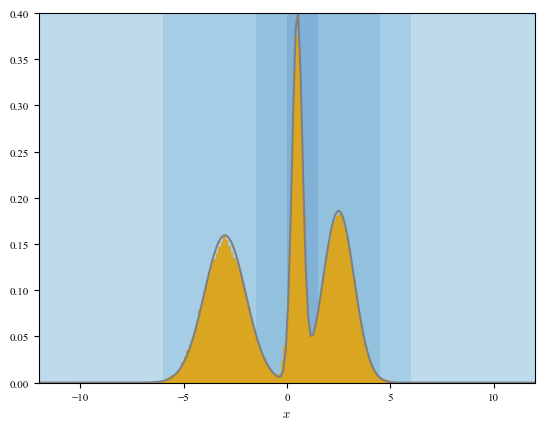

In [21]:
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.linspace(-12, 12, 200)


for leafnum,leaf in enumerate(tree.leaves):
    rect = Rectangle((leaf.x[0], 0.), leaf.dx[0], 1., lw=1, facecolor=cm.Blues(leaf.level/10,1.), ec='none', alpha=0.6)
    ax.add_patch(rect)

ax.plot(bins, gmm_pdf(bins), label="True PDF", c='grey')
ax.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')

ax.set_xlim(x_min,x_max)
ax.set_ylim(0.,0.4)
ax.set_xlabel('$x$', usetex=True)


Looks good!

## Final checks

Let's just check that we do get near-perfect results if we increase the number of grid cells a lot (we could achieve the same by dramatically decreasing the error tolerance in the `DensityTree` method above). Here is outcome of a fixed grid with 512 cells:

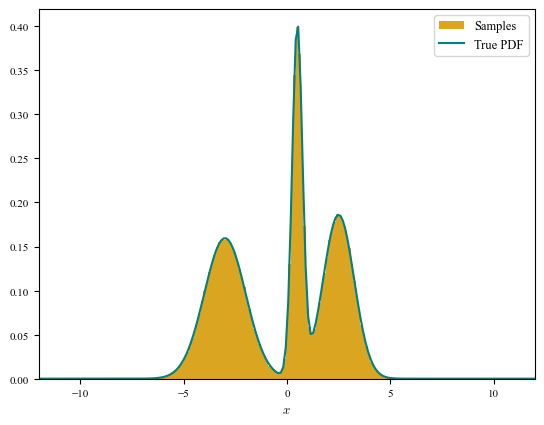

In [22]:
N_cells = 512
x_min = -12
x_max = 12
fixedgridhires = np.linspace(x_min,x_max,N_cells)

L = LintSampler(fixedgridhires,pdf=gmm_pdf,vectorizedpdf=True,seed=rng)
samples = L.sample(N=1000000)
bins = np.linspace(-12, 12, 200)
plt.hist(samples, bins=bins, density=True, label="Samples", fc='goldenrod')
plt.plot(bins, gmm_pdf(bins), label="True PDF", c='teal')
plt.xlabel('$x$', usetex=True)
plt.legend()
plt.xlim(-12, 12);

Just for fun, we can take the samples and fit a Gaussian mixture model just to check that we get results that roughly match the 'truths'.

In [23]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3).fit(samples[:, None])
order = np.argsort(gm.means_.squeeze())
print(f"Fitted means:\n {gm.means_[order].squeeze()}")
print(f"True means:\n {[-3.0, 0.5, 2.5]}\n")

print(f"Fitted widths:\n {np.sqrt(gm.covariances_[order]).squeeze()}")
print(f"True widths:\n {[1.0, 0.25, 0.75]}\n")

print(f"Fitted weights:\n {gm.weights_[order]}")
print(f"True weights:\n {[0.4, 0.25, 0.35]}\n")

Fitted means:
 [-3.70389332 -2.46195974  1.57951619]
True means:
 [-3.0, 0.5, 2.5]

Fitted widths:
 [0.73357459 0.60026584 1.23746954]
True widths:
 [1.0, 0.25, 0.75]

Fitted weights:
 [0.19497966 0.18563634 0.619384  ]
True weights:
 [0.4, 0.25, 0.35]



So, the fitted GMM parameters very closely match the truths.

## Comparison with importance sampling

When you have an expensive PDF in low (say, 1 or 2) dimensions, `lintsampler` can be advantageous over alternative techniques because you can get a comparably representative sample with fewer PDF evaluations.

In this section we will demonstrate this by comparing `lintsampler` with importance sampling on the GMM example from above.

Throughout we'll take 100000 samples:

In [24]:
N_SAMPLES = 100000

Let's set up a function to draw samples from an arbitrary PDF via importance sampling (using a uniform proposal distribution)

In [25]:
def generate_importance_samples(pdf, N, low, high, rng):
    proposals = rng.uniform(low=low, high=high, size=N)
    weights = pdf(proposals)
    return rng.choice(proposals, N, p=weights / weights.sum())

To test this out, let's apply it to the GMM PDF above:

In [26]:
x_imp = generate_importance_samples(gmm_pdf, N_SAMPLES, -12, 12, np.random.default_rng(42))

We can visualise the distribution of samples, alongside the true underlying distribution:

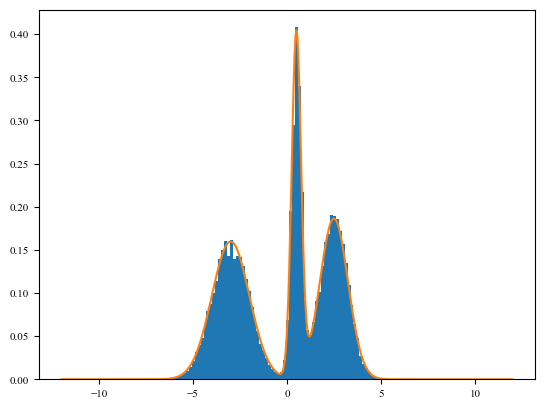

In [27]:
x_plot = np.linspace(-12, 12, 500)
plt.hist(x_imp, 80, density=True);
plt.plot(x_plot, gmm_pdf(x_plot));

For use below, let's also compute the average log-likelihood of the samples:

In [28]:
lnL_imp = np.log(gmm_pdf(x_imp)).mean()

Now, we'll draw samples from the GMM PDF with `lintsampler`. We'll take a fixed grid from $x=-12$ to $x=12$ with evenly sized cells (although a variable grid would be easy to set up and better suited to the problem, as we show in the example notebook in the docs). We have to choose a grid size for this, and we want to find a grid size where the 'performance' of the samples (as quantified by their average log-likelihood) is comparable to the performance of importance sampling. So, let's loop over grid sizes:

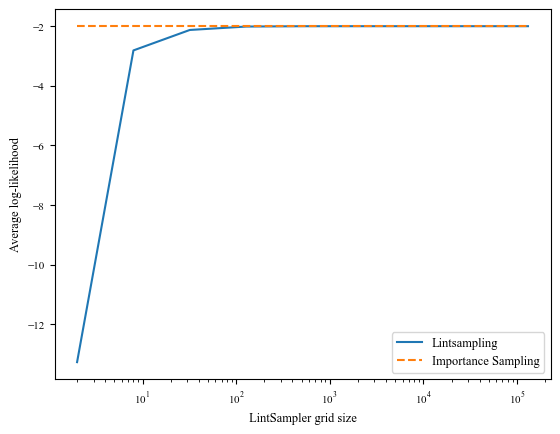

In [29]:
N_grid_arr = np.logspace(1, 17, 9, base=2, dtype=int) # 2**1, 2**3, 2**5, ... 2**17
lnL_ls = np.zeros(len(N_grid_arr))
for i, N_grid in enumerate(N_grid_arr):
    fixedgrid = np.linspace(-12, 12, N_grid)
    x_ls = LintSampler(fixedgrid, pdf=gmm_pdf, vectorizedpdf=True, seed=np.random.default_rng(42)).sample(N=N_SAMPLES)
    lnL_ls[i] = np.log(gmm_pdf(x_ls)).mean()

plt.plot(N_grid_arr, lnL_ls, label='Lintsampling')
plt.plot(N_grid_arr, lnL_imp * np.ones_like(N_grid_arr), ls='dashed', label='Importance Sampling')
plt.xscale('log')
plt.xlabel("LintSampler grid size")
plt.ylabel("Average log-likelihood")
plt.legend();

As expected, the performance of lintsampler is bad with coarse grids, but quickly improves, becoming comparable with importance sampling at around $10^2$ grid points. This is a key point: drawing $10^5$ samples with importance sampling required $10^5$ PDF evaluations, but the same sample size only required $10^2$ PDF evaluations with `lintsampler` to give just as 'good' a sample.

Of course, a caveat here is that the user needs to know what grid size will yield a good sample, but we argue that in most scenarios, the user has an a priori intuition for this. For example, in this (admittedly simplistic) test case, the width of the narrowest Gaussian is around 1/100th of the domain size, suggesting a natural grid size.

In this example, this reduction in evaluation count is not so important as the PDF is very cheap to evaluate, but one frequently encounters situations where this is not the case. In such situations, it is highly desirable to use a sampling technique which minimises the number of PDF evaluations. We can crudely mimic such a scenario by artifically slowing down our PDF by a factor proportional to the number of evaluations:

In [32]:
from time import sleep

def gmm_pdf_slow(x):
    sleep(len(x) * 1e-5)
    mu = np.array([-3.0, 0.5, 2.5])
    sig = np.array([1.0, 0.25, 0.75])
    w = np.array([0.4, 0.25, 0.35])
    return np.sum([w[i] * norm.pdf(x, mu[i], sig[i]) for i in range(3)], axis=0)

Let's see how long `lintsampler` takes to draw samples from this PDF using a decent grid size:

In [33]:
grid = np.linspace(-12, 12, 256)
%timeit LintSampler(grid, pdf=gmm_pdf_slow, vectorizedpdf=True, seed=np.random.default_rng(42)).sample(N=N_SAMPLES)

171 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Then let's compare it with how long importance sampling takes:

In [34]:
%timeit generate_importance_samples(gmm_pdf_slow, N_SAMPLES, -12, 12, np.random.default_rng(42))

1.03 s ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this specific case, `lintsampler` gives a 10x speedup. For very slow PDFs in the wild, the reduction in number of evaluations could well be extremely welcome!